In [1]:
import itertools
import random

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from scipy.special import softmax

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import simulations
import visualizations

# Defining Worlds and Actions

#### Defining All Possible Actions
Given a list of shapes and colors (which define features $\phi$), produce all possible actions $\cal{A}$. This implements Eq. 10 from the paper: 
$$
\phi: A \rightarrow \{0,1\}^K
$$

In [4]:
test_colors = ['blue', 'green']
test_shapes = ['circle', 'square']
test_actions = simulations.generate_actions_from_features(test_colors, test_shapes)

print("All possible actions: {}".format(test_actions))

All possible actions: [('blue', 'circle'), ('blue', 'square'), ('green', 'circle'), ('green', 'square')]


In [5]:
test_action_context = simulations.generate_context_from_actions([("green", "circle"), ("blue", "circle"), ("green", "square")])
test_action_context

,green,circle,blue,square
green circle,1.0,1.0,0.0,0.0
blue circle,0.0,1.0,1.0,0.0
green square,1.0,0.0,0.0,1.0


#### Possible Worlds

Generate a dataframe of all possible world states $w$. This is all combinatoric feature-value sets.  

In [6]:
test_features = test_colors + test_shapes
test_values = [-1, 1]

test_worlds = simulations.generate_worlds_from_feature_values(test_features, test_values)
test_worlds.head()

,blue,green,circle,square
0,-1,-1,-1,-1
1,-1,-1,-1,1
2,-1,-1,1,-1
3,-1,-1,1,1
4,-1,1,-1,-1


# Literal Listener: Beliefs and Actions

#### Belief Updates
Given a message $u$ which consists of a feature-value tuple $(\phi, \mathbb{R})$, condition worlds $w$ and return only those with are literally consistent with that utterance. This implements Eq. 3 / 11 from the paper:


\begin{equation}
    P_L(w \mid u) \propto \delta_{[ u ] (w)} P(w)
\end{equation} 

$$
p_L(w_L \mid u) = p_L(w_L \mid u_{\mathbb{1}_K} =  u_{\mathbb{R}})
$$

In [7]:
from listeners import StatelessLiteralListener

# Condition on a message
test_message = ('green', 1)
test_beliefs = StatelessLiteralListener.condition_worlds_on_message(test_worlds, test_message)

print("Before conditioning, {} possible worlds.".format(len(test_worlds)))
print("After conditioning, {} possible worlds.".format(len(test_beliefs)))
test_beliefs.head()

Before conditioning, 16 possible worlds.
After conditioning, 8 possible worlds.


,blue,green,circle,square,probability
4,-1,1,-1,-1,0.125
5,-1,1,-1,1,0.125
6,-1,1,1,-1,0.125
7,-1,1,1,1,0.125
12,1,1,-1,-1,0.125


#### Listener Rewards

Given an action dataframe $A$ and beliefs about rewards $w$, assign rewards to all actions. 

This implements Eq. 11 from the paper:

$$
R(a, w) = w^\top\phi(a)
$$

It can be called with either a Pandas `Series` or `DataFrame`. If `DataFrame`, will marginalize over beliefs and return expected rewards.

In [8]:
rewards = pd.Series({"blue": -1, "green": 1, "circle": 1, "square": -1})
print(test_action_context.index)
StatelessLiteralListener.estimate_rewards(rewards, test_action_context)

Index(['green circle', 'blue circle', 'green square'], dtype='object')


array([2., 0., 0.])

In [9]:
# With a belief dataframe from before:
print(test_action_context.index)
StatelessLiteralListener.estimate_rewards(test_beliefs, test_action_context)

Index(['green circle', 'blue circle', 'green square'], dtype='object')


array([1., 0., 1.])

#### Listener Policy
Given the listener's belief distribution and available actions, calculate their distribution over possible actions.

This implements Eq. 4 and 5 from the paper, 


\begin{equation}
    R_L(a, u) = \sum_{W}  R(a, w) P_L(w \mid u)
\end{equation}

$$
    \pi_L(a \mid u, A) = \frac{
    \exp\{\beta_L \cdot R_L(a, u)\}
}{
\sum_{a' \in A} \exp\{\beta_L \cdot R_L(a', u) \}
}
$$

In [10]:
literal_listener = StatelessLiteralListener(3, test_features, test_worlds)

test_message = ('green', 1)
literal_listener.action_policy(test_message, test_action_context)

,green,circle,blue,square,listener_reward,listener_choice_prob
green circle,1.0,1.0,0.0,0.0,1.0,0.487856
blue circle,0.0,1.0,1.0,0.0,0.0,0.024289
green square,1.0,0.0,0.0,1.0,1.0,0.487856


In [11]:
test_message = ('blue', 1)
literal_listener.action_policy(test_message, test_action_context)

,green,circle,blue,square,listener_reward,listener_choice_prob
green circle,1.0,1.0,0.0,0.0,0.0,0.045279
blue circle,0.0,1.0,1.0,0.0,1.0,0.909443
green square,1.0,0.0,0.0,1.0,0.0,0.045279


# Speaker Models

All of the speaker models implement `BaseSpeaker`, and take an utterance and action context to calculate a utility for that utterance.

These utilities are used to choose utterances.

### Belief-Oriented Speaker
The belief-oriented speaker optimizes the probability of a literal listener inferring the true world state.

From the paper, this is Eqs. 2 and 3:  

\begin{equation}
    U_\text{Belief}(u \mid w) = \log P_L(w \mid u)
\end{equation}

In [12]:
from speakers import BeliefSpeaker, ActionSpeaker, CombinedSpeaker

In [13]:
test_rewards = pd.Series({"green": 1, "blue": -1, "circle": 1, "square": -1})
bad_message = ("blue", 1)
good_message = ("green", 1)

test_belief_speaker = BeliefSpeaker(literal_listener, beta=3, w=test_rewards, name="Belief")

good_utility = test_belief_speaker.utility(good_message, test_action_context)
bad_utility = test_belief_speaker.utility(bad_message, test_action_context)

print("Belief speaker utility:")
print("\t{}: {}".format(good_message, good_utility))
print("\t{}: {}".format(bad_message, bad_utility))

Belief speaker utility:
	('green', 1): -2.0794415416798357
	('blue', 1): -23.025850929940457


## Action-Oriented Speaker
Will choose based on probability of the single best action. 

From the paper, this is Eq. 6 and 7:
$$
a^* \triangleq \text{argmax}_{a\in A} R(a, w)
$$

$$
U_\text{Action}(u \mid A, a^*) = \log[\pi_L(a^* \mid u, A)]
$$

In [14]:
test_action_speaker = ActionSpeaker(literal_listener, beta=3, w=test_rewards, name="Action")

good_utility = test_action_speaker.utility(good_message, test_action_context)
bad_utility = test_action_speaker.utility(bad_message, test_action_context)

print("Action speaker utility:")
print("\t{}: {}".format(good_message, good_utility))
print("\t{}: {}".format(bad_message, bad_utility))

Action speaker utility:
	('green', 1): -0.7177359186667025
	('blue', 1): -3.0949229564209606


## Combined Speaker
Will choose based on expected utility of actions. This implements Eq. 8 and 9 from the paper:

\begin{equation}
    R_S(u, w, A) = \sum_{a \in A} \pi_L(a \mid u, A) R(a, w)
\end{equation}

\begin{equation}
U_\text{Combined}(u \mid A, w) = R_S(u,w, A)
\end{equation}  

In [15]:
test_combined_speaker = CombinedSpeaker(literal_listener, beta=3, w=test_rewards, name="Combined")

good_utility = test_combined_speaker.utility(good_message, test_action_context)
bad_utility = test_combined_speaker.utility(bad_message, test_action_context)

print("Action speaker utility:")
print("\t{}: {}".format(good_message, good_utility))
print("\t{}: {}".format(bad_message, bad_utility))

Action speaker utility:
	('green', 1): 0.9757111023207369
	('blue', 1): 0.09055700148725816


# Experiment 1: Reference Games

In [16]:
# Define our set of shapes / colors
exp_1_colors = ['blue', 'green']
exp_1_shapes = ['circle', 'square']

# Define and plot our reward vector
exp_1_rewards = pd.Series({"green": 100, "circle": 100, "blue": -100, "square": -100})

# Restrict allowable utterances
exp_1_utterances = [('blue', 100), ('circle', 100), ('green', 100), ('square', 100)]

# Define the decision set
exp_1_action_tuples = [('blue', 'circle'), ('green', 'square'), ('green', 'circle')]
exp_1_action_context = simulations.generate_context_from_actions(exp_1_action_tuples)

In [17]:
exp_1_features = exp_1_colors + exp_1_shapes
exp_1_worlds = simulations.generate_worlds_from_feature_values(exp_1_features, exp_1_rewards.unique())

exp_1_listener = StatelessLiteralListener(beta=3, features=exp_1_features, possible_worlds=exp_1_worlds)

exp_1_belief_speaker = BeliefSpeaker(exp_1_listener, beta=3, w=exp_1_rewards, name="Belief")
exp_1_action_speaker = ActionSpeaker(exp_1_listener, beta=3, w=exp_1_rewards, name="Action")
exp_1_combined_speaker = CombinedSpeaker(exp_1_listener, beta=2, w=exp_1_rewards, name="Combined")

exp_1_speakers = [exp_1_belief_speaker, exp_1_action_speaker, exp_1_combined_speaker]

df = simulations.speakers_utterance_probabilities_single_action_context(exp_1_action_context, exp_1_speakers, exp_1_utterances, exp_1_rewards)
simulations.summarize_speakers_performance(df, exp_1_speakers)

,speaker,action_context,prob_truthful,prob_optimal_action,expected_rewards
0,Belief,All,1.0,0.5,100.0
1,Action,All,1.0,0.5,100.0
2,Combined,All,1.0,0.5,100.0


# Experiment 2: Single-Shot Bandits

In [18]:
# Define our set of shapes / colors
exp_2_colors = ['blue', 'green', 'red']
exp_2_shapes = ['circle', 'square', 'triangle']
exp_2_features = exp_2_colors + exp_2_shapes

# Generate action contexts
exp_2_actions = simulations.generate_actions_from_features(exp_2_colors, exp_2_shapes)
exp_2_action_contexts = list(itertools.combinations(exp_2_actions, 3))

# Define and our reward vector
exp_2_rewards = pd.Series({"green": 2, "red": 0,  "blue": -2, "circle": 1, "triangle": 0, "square": -1})

# Define allowable utterances as all valid feature / value tuples
exp_2_utterances = list(itertools.product(exp_2_features, exp_2_rewards.unique()))

# Define a listener
exp_2_worlds = simulations.generate_worlds_from_feature_values(exp_2_features, exp_2_rewards.unique())
exp_2_listener = StatelessLiteralListener(beta=3, features=exp_2_features, possible_worlds=exp_2_worlds)

exp_2_belief_speaker = BeliefSpeaker(exp_2_listener, beta=3, w=exp_2_rewards, name="Belief")
exp_2_action_speaker = ActionSpeaker(exp_2_listener, beta=3, w=exp_2_rewards, name="Action")
exp_2_combined_speaker = CombinedSpeaker(exp_2_listener, beta=2, w=exp_2_rewards, name="Combined")

exp_2_speakers = [exp_2_belief_speaker, exp_2_action_speaker, exp_2_combined_speaker]

,speaker,action_context,prob_truthful,prob_optimal_action,expected_rewards
0,Belief,All,1.000000,0.482780,-0.052623
1,Action,All,0.359497,0.737039,0.455710
2,Combined,All,0.330118,0.626946,0.481718


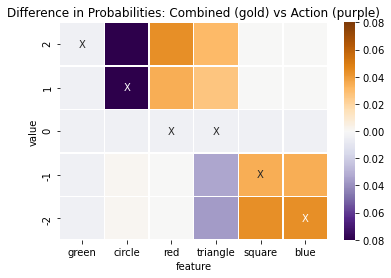

In [19]:
demo_bandit = (('blue', 'square'), ('red', 'triangle'), ('red', 'circle'))
demo_action_context = simulations.generate_context_from_actions(demo_bandit)

df = simulations.speakers_utterance_probabilities_single_action_context(demo_action_context, exp_2_speakers, exp_2_utterances, exp_2_rewards)
visualizations.heatmap_speaker_action_dataframe(df, exp_2_combined_speaker, exp_2_rewards, speaker_two=exp_2_action_speaker, vmax=.08, vmin=-.08)

simulations.summarize_speakers_performance(df, exp_2_speakers)

### Average over all possible bandit configurations

In [20]:
exp_two_full_df = simulations.speaker_utterance_probabilities_multiple_action_contexts(exp_2_action_contexts, exp_2_speakers, exp_2_utterances, exp_2_rewards)

print("Evaluated over {} bandit configurations.".format(exp_two_full_df.action_context.nunique()))

Evaluated over 84 bandit configurations.


In [21]:
exp_two_local = simulations.summarize_speakers_performance(exp_two_full_df, speaker_list=exp_2_speakers)
exp_two_local.groupby("speaker").mean()

,prob_truthful,prob_optimal_action,expected_rewards
speaker,,,
Action,0.329731,0.771643,1.184601
Belief,1.000000,0.499266,0.538652
Combined,0.359215,0.742426,1.275542


In [22]:
# Generalization: collapse utterance probabilities over action contexts, then evaluate expected rewards
exp_two_utterance_probability_df = exp_two_full_df.groupby("utterance").mean().reset_index()
simulations.summarize_speakers_performance(exp_two_utterance_probability_df, exp_2_speakers)

,speaker,action_context,prob_truthful,prob_optimal_action,expected_rewards
0,Belief,All,1.000000,0.499266,0.538652
1,Action,All,0.329731,0.489996,0.485632
2,Combined,All,0.359215,0.499885,0.521622


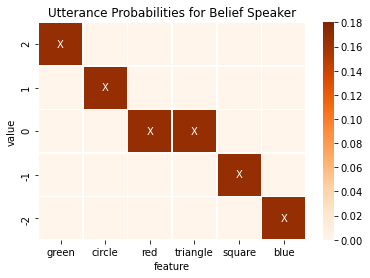

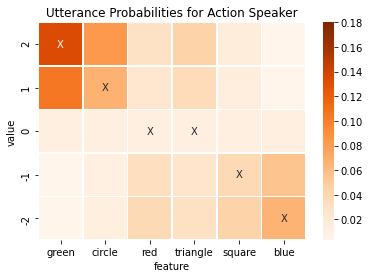

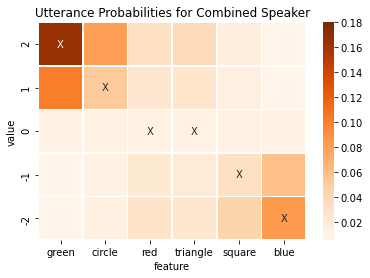

In [23]:
for s in exp_2_speakers:
    visualizations.heatmap_speaker_action_dataframe(exp_two_full_df, s, exp_2_rewards, vmax=.18, cmap='Oranges')

# Experiment 3: Full Context

The speakers now choose an utterance while looking at **all 9** possible bandits, $\cal{A}$. We generate utterance probabilities based on this single action context, then use the experiment 2 results and re-weight outcomes by the new distribution over utterances.

In [24]:
print(exp_2_actions)

exp_3_action_context = exp_2_actions
exp_three_full_df = simulations.speaker_utterance_probabilities_multiple_action_contexts([exp_3_action_context], exp_2_speakers, exp_2_utterances, exp_2_rewards)
exp_three_full_df.drop(["expected_rewards", "prob_optimal_action"], axis=1, inplace=True)

exp_three_full_df.head()

[('blue', 'circle'), ('blue', 'square'), ('blue', 'triangle'), ('green', 'circle'), ('green', 'square'), ('green', 'triangle'), ('red', 'circle'), ('red', 'square'), ('red', 'triangle')]


,utterance,feature,value,truthful,Belief,Action,Combined,Belief_prob,Action_prob,Combined_prob,action_context
0,"(blue, 2)",blue,2,False,-23.025851,-7.103558,-1.985201,5.086263e-21,3.220013e-09,0.000143,['blue circle' 'blue square' 'blue triangle' '...
1,"(blue, 0)",blue,0,False,-23.025851,-2.197225,0.000000,5.086263e-21,7.947630e-03,0.007575,['blue circle' 'blue square' 'blue triangle' '...
2,"(blue, -2)",blue,-2,True,-8.047190,-1.792998,0.996286,1.666667e-01,2.672377e-02,0.055560,['blue circle' 'blue square' 'blue triangle' '...
3,"(blue, 1)",blue,1,False,-23.025851,-4.193535,-1.728329,5.086263e-21,1.991946e-05,0.000239,['blue circle' 'blue square' 'blue triangle' '...
4,"(blue, -1)",blue,-1,False,-23.025851,-1.816348,0.927133,5.086263e-21,2.491582e-02,0.048383,['blue circle' 'blue square' 'blue triangle' '...


In [25]:
# Join Exp 3 utterance probabilities back to Exp 2 utterance outcomes
exp_two_utterance_outcomes = exp_two_utterance_probability_df[["utterance", "expected_rewards", "prob_optimal_action"]].set_index("utterance")
exp_three_results = exp_three_full_df.set_index("utterance").join(exp_two_utterance_outcomes).reset_index()
exp_three_results.head()

,utterance,feature,value,truthful,Belief,Action,Combined,Belief_prob,Action_prob,Combined_prob,action_context,expected_rewards,prob_optimal_action
0,"(blue, 2)",blue,2,False,-23.025851,-7.103558,-1.985201,5.086263e-21,3.220013e-09,0.000143,['blue circle' 'blue square' 'blue triangle' '...,-1.276990e+00,0.104835
1,"(blue, 0)",blue,0,False,-23.025851,-2.197225,0.000000,5.086263e-21,7.947630e-03,0.007575,['blue circle' 'blue square' 'blue triangle' '...,6.410216e-17,0.361111
2,"(blue, -2)",blue,-2,True,-8.047190,-1.792998,0.996286,1.666667e-01,2.672377e-02,0.055560,['blue circle' 'blue square' 'blue triangle' '...,9.591251e-01,0.589918
3,"(blue, 1)",blue,1,False,-23.025851,-4.193535,-1.728329,5.086263e-21,1.991946e-05,0.000239,['blue circle' 'blue square' 'blue triangle' '...,-1.124562e+00,0.133964
4,"(blue, -1)",blue,-1,False,-23.025851,-1.816348,0.927133,5.086263e-21,2.491582e-02,0.048383,['blue circle' 'blue square' 'blue triangle' '...,8.670348e-01,0.566003


In [26]:
simulations.summarize_speakers_performance(exp_three_results, exp_2_speakers)

,speaker,action_context,prob_truthful,prob_optimal_action,expected_rewards
0,Belief,['blue circle' 'blue square' 'blue triangle' '...,1.000000,0.499266,0.538652
1,Action,['blue circle' 'blue square' 'blue triangle' '...,0.440370,0.566147,0.748069
2,Combined,['blue circle' 'blue square' 'blue triangle' '...,0.534047,0.626699,0.948940


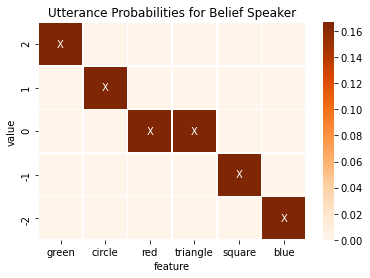

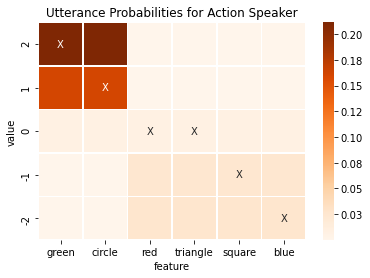

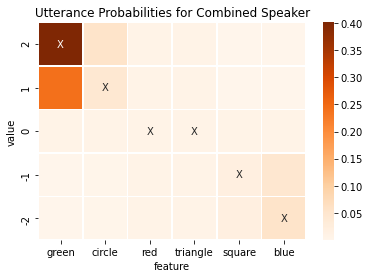

In [27]:
for s in exp_2_speakers:
    visualizations.heatmap_speaker_action_dataframe(exp_three_results, s, exp_2_rewards, cmap="Oranges")

# Optimal Speakers

In [28]:
optimal_action_speaker = ActionSpeaker(exp_2_listener, beta=1e5, w=exp_2_rewards, name="OptimalAction")
optimal_combined_speaker = CombinedSpeaker(exp_2_listener, beta=1e5, w=exp_2_rewards, name="OptimalCombined")
optimal_belief_speaker = BeliefSpeaker(exp_2_listener, beta=1e5, w=exp_2_rewards, name="OptimalBelief")

In [29]:
optimal_speakers = [optimal_belief_speaker, optimal_action_speaker, optimal_combined_speaker]

optimal_full_df = simulations.speaker_utterance_probabilities_multiple_action_contexts(exp_2_action_contexts, optimal_speakers, exp_2_utterances, exp_2_rewards)

## Optimal - Experiment 2

#### Local Results
Optimal speakers do much better locally.

In [30]:
optimal_local_speakers = simulations.summarize_speakers_performance(optimal_full_df, speaker_list=optimal_speakers)
optimal_local_speakers.groupby("speaker").mean()

,prob_truthful,prob_optimal_action,expected_rewards
speaker,,,
OptimalAction,0.458333,0.942236,1.630993
OptimalBelief,1.000000,0.499266,0.538652
OptimalCombined,0.488095,0.942236,1.666575


### Generalization
But their generalization performance suffers still suffers.

In [31]:
# Generalization: collapse utterance probabilities over action contexts, then evaluate expected rewards
optimal_local_utterance_probability_df = optimal_full_df.groupby("utterance").mean().reset_index()
simulations.summarize_speakers_performance(optimal_local_utterance_probability_df, optimal_speakers)

,speaker,action_context,prob_truthful,prob_optimal_action,expected_rewards
0,OptimalBelief,All,1.000000,0.499266,0.538652
1,OptimalAction,All,0.458333,0.544040,0.690351
2,OptimalCombined,All,0.488095,0.550010,0.710317


## Optimal - Experiment 3

As before, use utterance-based outcomes from Experiment 2 and join in new distribution over utterances from global context.

In [32]:
optimal_global_utterance_probability_df = simulations.speaker_utterance_probabilities_multiple_action_contexts([exp_3_action_context], optimal_speakers, exp_2_utterances, exp_2_rewards)
optimal_global_utterance_probability_df.drop(["expected_rewards", "prob_optimal_action"], axis=1, inplace=True)

exp_two_utterance_outcomes = exp_two_utterance_probability_df[["utterance", "expected_rewards", "prob_optimal_action"]].set_index("utterance")

optimal_global_results = optimal_global_utterance_probability_df.set_index("utterance").join(exp_two_utterance_outcomes).reset_index()

simulations.summarize_speakers_performance(optimal_global_results, optimal_speakers)

,speaker,action_context,prob_truthful,prob_optimal_action,expected_rewards
0,OptimalBelief,['blue circle' 'blue square' 'blue triangle' '...,1.0,0.499266,0.538652
1,OptimalAction,['blue circle' 'blue square' 'blue triangle' '...,0.5,0.624145,0.957743
2,OptimalCombined,['blue circle' 'blue square' 'blue triangle' '...,1.0,0.731498,1.276990
